<ins>Logical Workflow PA Project</ins>

0. Call Data from SQL Server and save to local .pkl. Filter by TBM 1 and time span ('2022/02/01', '2022/04/01')
1. Join data for a complete dataset
2. Initial drop duplicates, Filter (by Equipment ID: TBM 1 and remove Trial Recipes), key generation, cycle time generation and EDA
3. Left Merge Alarm mapping and Alarm hisroy on Created Key.
4. Alarm Discovery: Alarm to GT allocation: Calculate PAAP start and finish times if needed. Do NOT Filter alarms by Type e.g.  FF, CF and MC, assin name in#dexes. Link these alarm name indexes that are occurring for the same green tire at those times identified as PA. Create GT to Alarm Index Mapping.
5. One Hot encode Alarm Indexes before we carry out feature selction to see relevant alarms.
6. Feature selection: Initial Filter using statistical univariate filter methods. 
7. Feature selection: Narrow down using ML Models. Identify which steps are posing the issue (i.e. is it sidewall, inner liner, is it transport time etc.)
8. View Selected Alarms and Discuss with Operations Team
9. With an Alarm, classifed the GT's which had this alarm (allocated on entire start/produced time instead). We then join the alarm mapping with alarm history and join this table to the GT's in production data and perform counts and validate apparent erroneous durations. Sort the alarms into 'Errors' and 'Valid'. i.e. Alarm Duration < PAAP & Cycle Time is a Valid Scenario. Errors are EITHER Alarm Duration > PAAP OR Alarm Duration > PAAP & Cycle Time
    Have decided to take the subset of Duration < Cycle Time as GT's that make feasible sense.
10. Carry out More detailed analysis to gauge size of the prize. Here we have taken the 95th percentile of cycle times to remove outlier GT's. We had already previously removed Trial Recipes. Then:
    •	Analyse if they have taken each alarm once or twice. Need to sort by Null i.e. (Mahesh is handling)
    •	Count of 'Valid' Alarms. Calculate percentage out of all GT's Produced 
    •	Recalculate time saving per cycle time for start_time and ProducedOn Time. i.e. Redo Allocation of GT's
    •	See Date dependence of PA alarms. (one day may be particularly bad due to converyor belt issue, or Recipe   inherent etc.) (Automation Conveyor may have an issue on one particylar day). See if Date Dependent
11. Continuation of 10, to carry out more detailed analysis to gauge size of the prize
    •	See correlation coeff with Duration and Cycle time/PAAP time
    •	General Analysis of PAAP Times
    •	Check next and previous tyres for the Errors.   
    •	Investigate for other TBM's
12.	Plot these comparisons and highlight your observations. Add any other analysis as we go along: 
    •	Total CT variation - m/c wise
    •	CT variation - application wise
    •	Total CT variation - Diameter wise
    •	Total CT variation - Recipe wise
    •	Number of changeovers - m/c wise 
    •	Number of changeovers - due to recipe, due to diameter

## Meeting 19-05-2022 with Raj
1. The PRE-ASSEMBLY, LENGTH OUT OF TOLERANCE alarm **Duration is NOT linked to machine stoppage time**
2. Process:
    1. Alarm is triggered when Material enters the conveyor (Before the drum) and the length is measured and compared to the set-point. If this is incorrect, then Alarm is triggered **But does not stop machine yet**
    2. This alarm runs for 25 seconds in most cases (If the machine is running in full auto mode). This is the time it takes to be delivered to drum on conveyor and for PAAP.
    3. Variations: If the alarm runs for longer than 25 seconds, could be the case that the material is still placed on conveyor, but is not applied on the drum e.g. Maintence people are loading bodyply casette etc. This can cause the alarm duration to be longer. 
    3. PAAP occurs, and the material is applied on the drum. This is usually 4-5 seconds long. This time is pretty consistent from our evaluation/data analysis aswell.
    4. Once PAAP application is done, the machine will stop. **This is when the alarm is stopped**
    5. The operator carries out any manual fixes on the drum and restarts the machine. 
3. We do not have the Data on the actual machine stoppage time, to understand this, we will need to create a solution

In [1]:
import pandas as pd
from helpers import TBM, bcolors, Feature_Selection, Data_Functions
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px

TBM = TBM()
p = bcolors()
FS = Feature_Selection()
DF = Data_Functions()

In [2]:
subset = pd.read_pickle('./pkl/valid_alarm_GTs')
df_tbm = pd.read_pickle("./pkl/df_tbm_PAAP_times.pkl")
df_PA_tbm_join_Alarm = pd.read_pickle('./pkl/PA_Alarms_joined_with_tbm_data.pkl')

In [3]:
subset.head()

,start_time,ProducedOn,Duration,TimeStamp,VRL_VHMC_MES_CCPR_CYCLE_TIME_PAAP,cycle_time_s,RecipeName,Id,key,Type,Name,EquipmentID_x
0,2022-02-02 11:04:03,2022-02-02 11:06:32,37,2022-02-02 11:04:14.372858700,74.818001,149,GG225517HYPNW,11157450,95982TBM_1,OM,"PRE-ASSEMBLY, LENGTH OUT OF TOLERANCE",TBM 1
1,2022-02-02 06:13:33,2022-02-02 06:16:52,37,2022-02-02 06:13:42.141255800,153.955994,199,GG236517HTRNH,11154639,95982TBM_1,OM,"PRE-ASSEMBLY, LENGTH OUT OF TOLERANCE",TBM 1
2,2022-02-02 06:22:23,2022-02-02 06:23:49,28,2022-02-02 06:22:30.771678400,42.612000,86,GG236517HTRNH,11154772,95982TBM_1,OM,"PRE-ASSEMBLY, LENGTH OUT OF TOLERANCE",TBM 1
3,2022-02-02 06:25:15,2022-02-02 06:26:27,54,2022-02-02 06:25:23.882659000,27.575001,72,GG236517HTRNH,11154774,95982TBM_1,OM,"PRE-ASSEMBLY, LENGTH OUT OF TOLERANCE",TBM 1
4,2022-02-02 06:26:27,2022-02-02 06:28:02,37,2022-02-02 06:26:46.046805600,39.584000,95,GG236517HTRNH,11154775,95982TBM_1,OM,"PRE-ASSEMBLY, LENGTH OUT OF TOLERANCE",TBM 1


In [4]:
DF.spearman(subset.cycle_time_s, subset.VRL_VHMC_MES_CCPR_CYCLE_TIME_PAAP)

Spearmans correlation coefficient:  0.19352960239419983
Samples are correlated (reject H0)  2.248538098344327e-31
The statistical test reports a positive correlation with a value of 0.0. The p-value is close to zero, which means that the likelihood of observing the data given that the samples are uncorrelated is very unlikely (e.g. 95% confidence) and that we can reject the null hypothesis that the samples are uncorrelated.


The statistical test reports a positive correlation with a value of 0.2. The p-value is close to zero, which means that the likelihood of observing the data given that the samples are uncorrelated is very unlikely (e.g. 95% confidence) and that we can reject the null hypothesis that the samples are uncorrelated.

In [5]:
DF.kendall(subset.cycle_time_s, subset.VRL_VHMC_MES_CCPR_CYCLE_TIME_PAAP)

Kendall correlation coefficient:  0.1467306800368516
Samples are correlated (reject H0)  4.099883502056398e-39
Running the example calculates the Kendall’s correlation coefficient as 0.0, which is correlated. The p-value is close to zero, which means that the likelihood of observing the data given that the samples are uncorrelated is very unlikely (e.g. 95% confidence) and that we can reject the null hypothesis that the samples are uncorrelated.


In [6]:
DF.spearman(subset.cycle_time_s, subset.Duration)
DF.kendall(subset.cycle_time_s, subset.Duration)

Spearmans correlation coefficient:  0.06307159075524205
Samples are correlated (reject H0)  0.00016647484870675546
The statistical test reports a positive correlation with a value of 0.0. The p-value is close to zero, which means that the likelihood of observing the data given that the samples are uncorrelated is very unlikely (e.g. 95% confidence) and that we can reject the null hypothesis that the samples are uncorrelated.
Kendall correlation coefficient:  0.04944966071837283
Samples are correlated (reject H0)  1.695833213958184e-05
Running the example calculates the Kendall’s correlation coefficient as 0.0, which is correlated. The p-value is close to zero, which means that the likelihood of observing the data given that the samples are uncorrelated is very unlikely (e.g. 95% confidence) and that we can reject the null hypothesis that the samples are uncorrelated.


In [7]:
DF.spearman(df_tbm.VRL_VHMC_MES_CCPR_CYCLE_TIME_TDST, df_tbm.VRL_VHMC_MES_CCPR_CYCLE_TIME_GTRU)
DF.kendall(df_tbm.VRL_VHMC_MES_CCPR_CYCLE_TIME_TDST, df_tbm.VRL_VHMC_MES_CCPR_CYCLE_TIME_GTRU)

Spearmans correlation coefficient:  0.010793282701079739
Samples are correlated (reject H0)  0.00033159147693346495
The statistical test reports a positive correlation with a value of 0.0. The p-value is close to zero, which means that the likelihood of observing the data given that the samples are uncorrelated is very unlikely (e.g. 95% confidence) and that we can reject the null hypothesis that the samples are uncorrelated.
Kendall correlation coefficient:  0.007469851036813696
Samples are correlated (reject H0)  0.0002034595678247051
Running the example calculates the Kendall’s correlation coefficient as 0.0, which is correlated. The p-value is close to zero, which means that the likelihood of observing the data given that the samples are uncorrelated is very unlikely (e.g. 95% confidence) and that we can reject the null hypothesis that the samples are uncorrelated.


In [60]:
df_tbm

,ProducedOn,EquipmentID,ProductionDataId,UserGroupName,Name_of_Active_Operator,RecipeName,Name_of_Active_Production_Order,date/time,Barcode_on_build_tire,GT_Code_of_the_built_tire,...,VRL_VHMC_MES_CCPR_CYCLE_TIME_TDST,VRL_VHMC_MES_CCPR_CYCLE_TIME_SWST,VRL_VHMC_MES_CCPR_CYCLE_TIME_GTRU,Id,start_time,cycle_time_s,naive_addition_of_step_times,sum_subsequent_steps,PAAP_Finish_time,PAAP_Start_time
0,2022-02-01 06:03:43,TBM 1,1347468,Operator,Operator 065,GG224517HYPXY,T2206001N000,20220201 06:03:43,0015600676,GG224517HYPXY,...,5.498,0.0,2.480,11141585,2022-02-01 06:02:06,97,219.620006,85.318002,2022-02-01 06:02:17.681997776,2022-02-01 06:02:12.754997730
1,2022-02-01 06:04:28,TBM 1,1347469,Operator,Operator 065,GG224517HYPXY,T2206001N000,20220201 06:04:28,0015600677,GG224517HYPXY,...,5.667,0.0,2.480,11141586,2022-02-01 06:03:43,45,137.105000,36.230000,2022-02-01 06:03:51.770000100,2022-02-01 06:03:47.783000111
2,2022-02-01 06:05:33,TBM 1,1347470,Operator,Operator 065,GG224517HYPXY,T2206001N000,20220201 06:05:33,0015600678,GG224517HYPXY,...,5.654,0.0,2.397,11141588,2022-02-01 06:04:28,65,92.177000,43.610000,2022-02-01 06:04:49.389999986,2022-02-01 06:04:45.452999950
3,2022-02-01 06:06:24,TBM 1,1347471,Operator,Operator 065,GG224517HYPXY,T2206001N000,20220201 06:06:24,0015600679,GG224517HYPXY,...,5.572,0.0,2.448,11141590,2022-02-01 06:05:33,51,102.747001,34.745000,2022-02-01 06:05:49.255000234,2022-02-01 06:05:45.262000203
4,2022-02-01 06:07:52,TBM 1,1347472,Operator,Operator 065,GG224517HYPXY,T2206001N000,20220201 06:07:52,0015600680,GG224517HYPXY,...,5.718,0.0,2.468,11141591,2022-02-01 06:06:24,88,186.372003,79.013001,2022-02-01 06:06:32.986998677,2022-02-01 06:06:29.088998675
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110579,2022-05-16 05:53:49,TBM 1,1458476,DEFAULT,DEFAULT,GG215017ULAXY,T22210001Y00,20220516 05:53:49,0016499089,GG215017ULAXY,...,5.394,0.0,1.917,12467918,2022-05-16 05:53:10,39,76.988000,30.845001,2022-05-16 05:53:18.154999495,2022-05-16 05:53:14.217999459
110580,2022-05-16 05:54:27,TBM 1,1458477,DEFAULT,DEFAULT,GG215017ULAXY,T22210001Y00,20220516 05:54:27,0016499090,GG215017ULAXY,...,5.436,0.0,1.919,12467919,2022-05-16 05:53:49,38,72.697999,30.192000,2022-05-16 05:53:56.807999969,2022-05-16 05:53:52.876000047
110581,2022-05-16 05:55:05,TBM 1,1458478,Operator,Operator 081,GG215017ULAXY,T22210001Y00,20220516 05:55:05,0016499091,GG215017ULAXY,...,5.481,0.0,1.917,12467920,2022-05-16 05:54:27,38,72.351000,30.302000,2022-05-16 05:54:34.698000312,2022-05-16 05:54:30.771000266
110582,2022-05-16 05:57:04,TBM 1,1458479,Operator,Operator 081,GG215017ULAXY,T22210001Y00,20220516 05:57:04,0016499092,GG215017ULAXY,...,5.469,0.0,1.944,12468000,2022-05-16 05:55:05,119,152.235999,110.093999,2022-05-16 05:55:13.906001449,2022-05-16 05:55:09.924001336


In [8]:
p.printg(f'Pearson Coefficient between Cycle Time and PAAP Time: {p.ENDC} {DF.corr(df=subset, method="pearson", var1="cycle_time_s", var2="Duration")}')
p.printg(f'Kendall Coefficient between Cycle Time and PAAP Time: {p.ENDC} {DF.corr(df=subset, method="kendall", var1="cycle_time_s", var2="Duration")}')
p.printg(f'Spearman Coefficient between Cycle Time and PAAP Time: {p.ENDC} {DF.corr(df=subset, method="spearman", var1="cycle_time_s", var2="Duration")}')

Pearson Coefficient between Cycle Time and PAAP Time:  0.19424773700580322
Kendall Coefficient between Cycle Time and PAAP Time:  0.04944966071837283
Spearman Coefficient between Cycle Time and PAAP Time:  0.06307159075524206


In [9]:
p.printg(f'Pearson Coefficient between Cycle Time and PAAP Time: {p.ENDC} {DF.corr(df=subset, method="pearson", var1="cycle_time_s", var2="VRL_VHMC_MES_CCPR_CYCLE_TIME_PAAP")}')
p.printg(f'Kendall Coefficient between Cycle Time and PAAP Time: {p.ENDC} {DF.corr(df=subset, method="kendall", var1="cycle_time_s", var2="VRL_VHMC_MES_CCPR_CYCLE_TIME_PAAP")}')
p.printg(f'Spearman Coefficient between Cycle Time and PAAP Time: {p.ENDC} {DF.corr(df=subset, method="spearman", var1="cycle_time_s", var2="VRL_VHMC_MES_CCPR_CYCLE_TIME_PAAP")}')

Pearson Coefficient between Cycle Time and PAAP Time:  0.06174074443692859
Kendall Coefficient between Cycle Time and PAAP Time:  0.1467306800368516
Spearman Coefficient between Cycle Time and PAAP Time:  0.19352960239419986


Little to no correlation between Alarm Duration and Cycle Time (s)

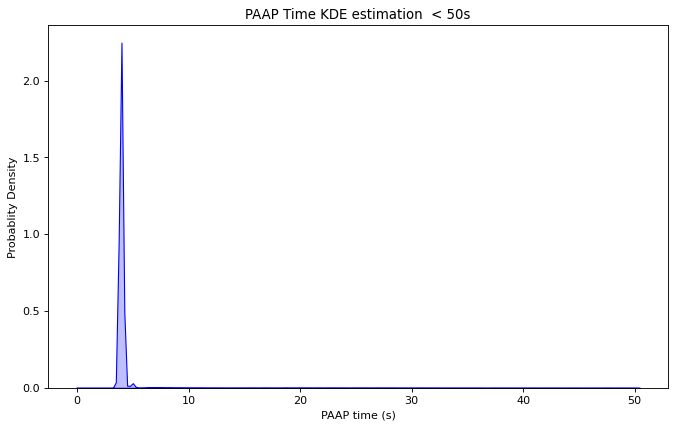

In [10]:
DF.KDE_dist_plotter(series=df_tbm.VRL_VHMC_MES_CCPR_CYCLE_TIME_PAAP[df_tbm.VRL_VHMC_MES_CCPR_CYCLE_TIME_PAAP < 50], title='PAAP Time KDE estimation  < 50s', xlabel='PAAP time (s)')

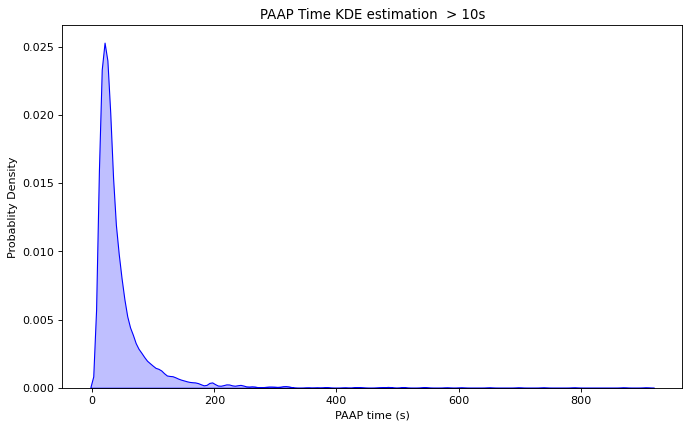

In [11]:
DF.KDE_dist_plotter(series=df_tbm.VRL_VHMC_MES_CCPR_CYCLE_TIME_PAAP[df_tbm.VRL_VHMC_MES_CCPR_CYCLE_TIME_PAAP  > 10], title='PAAP Time KDE estimation  > 10s', xlabel='PAAP time (s)')

In [12]:
sec = 10
p.printg(f'Percentage of GT\'s with PAAP time above {sec} seconds: {p.ENDC} {round((len(df_tbm.VRL_VHMC_MES_CCPR_CYCLE_TIME_PAAP[df_tbm.VRL_VHMC_MES_CCPR_CYCLE_TIME_PAAP > sec])/len(df_tbm))*100,2)}%')

Percentage of GT's with PAAP time above 10 seconds:  3.9%


In [13]:
def threshold_plotter():
    '''Percentage of GT\'s with PAAP time above x'''
    d = []
    for i in np.arange(0, 100, 0.01):
        d.append(
            {
                'PAAP_time': i,
                'percentage_above_threshold': (len(df_tbm.VRL_VHMC_MES_CCPR_CYCLE_TIME_PAAP[df_tbm.VRL_VHMC_MES_CCPR_CYCLE_TIME_PAAP > i])/len(df_tbm))*100
            }
        )
    plt.figure(figsize=(10, 6), dpi=80)
    fig = px.line(pd.DataFrame(d), x="PAAP_time", y="percentage_above_threshold", title='Percentage of GT\'s with PAAP time above Time Threshold')
    fig.show()

In [14]:
threshold_plotter()

<Figure size 800x480 with 0 Axes>

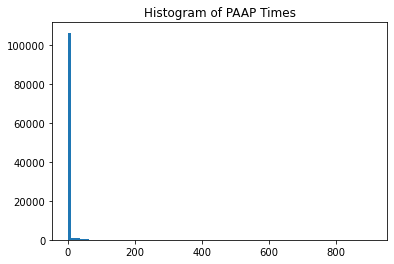

Mean:  5.660758816885375
Variance:  198.4414289843274
Skew:  22.386014068101456
Kurtosis:  844.3918320187137


In [15]:
vals = df_tbm.VRL_VHMC_MES_CCPR_CYCLE_TIME_PAAP
plt.hist(vals, 100)
plt.title('Histogram of PAAP Times')
plt.show()
DF.moments(df_tbm.VRL_VHMC_MES_CCPR_CYCLE_TIME_PAAP)

![Skey And Kurtosis](./img/=f.png "Skew & Kurtosis")

Moments in statistics:
1) First Moment: Measure of the central location. (MEAN)
2) Second Moment: Measure of dispersion/spread.(VARIANCE)
3) Third Moment: Measure of asymmetry.
4) Fourth Moment: Measure of outliers/tailedness.

Kurtosis Value is very very high. Fourth moment is “kurtosis”. How thick is the tail, and how sharp is the peak, compared to a
normal distribution? This has a very high kurtosos, i.e. very very sharp. Almost no significant variation

In [16]:
df_tbm.sort_values(by='ProducedOn', inplace=True)
df_tbm = df_tbm.reset_index(drop=True)

1. Scenario 1 : Alarm Duration < PAAP Times
2. Scenario 2 : Alarm Duration > PAAP Times 
3. Scenario 3 : Alarm Duration > PAAP Times & Cycle Time

In [17]:
p.printg(f'no. Total Alarms: {p.ENDC} {len(df_PA_tbm_join_Alarm)}')
scen1 = df_PA_tbm_join_Alarm.loc[(df_PA_tbm_join_Alarm['Duration'] < df_PA_tbm_join_Alarm.VRL_VHMC_MES_CCPR_CYCLE_TIME_PAAP)]
p.printg(f'no. Scenario 1 Alarms: {p.ENDC} {len(scen1)}')
scen2 = df_PA_tbm_join_Alarm.loc[(df_PA_tbm_join_Alarm['Duration'] > df_PA_tbm_join_Alarm.VRL_VHMC_MES_CCPR_CYCLE_TIME_PAAP)]
p.printg(f'no. Scenario 2 Alarms: {p.ENDC} {len(scen2)}')
scen3 = df_PA_tbm_join_Alarm.loc[(df_PA_tbm_join_Alarm['Duration'] > df_PA_tbm_join_Alarm.VRL_VHMC_MES_CCPR_CYCLE_TIME_PAAP) & (df_PA_tbm_join_Alarm['Duration'] > df_PA_tbm_join_Alarm.cycle_time_s)]
p.printg(f'no. Scenario 3 Alarms: {p.ENDC} {len(scen3)}')
print('\n')

p.printg(f'Scenario 1 PAAP mean: {p.ENDC} {scen1.VRL_VHMC_MES_CCPR_CYCLE_TIME_PAAP.mean()}')
p.printg(f'Scenario 2 PAAP mean: {p.ENDC} {scen2.VRL_VHMC_MES_CCPR_CYCLE_TIME_PAAP.mean()}')
p.printg(f'Scenario 3 PAAP mean: {p.ENDC} {scen3.VRL_VHMC_MES_CCPR_CYCLE_TIME_PAAP.mean()}')

no. Total Alarms:  3752
no. Scenario 1 Alarms:  1218
no. Scenario 2 Alarms:  2534
no. Scenario 3 Alarms:  190


Scenario 1 PAAP mean:  58.18882346016237
Scenario 2 PAAP mean:  12.825110085102734
Scenario 3 PAAP mean:  18.392905250348544


In [15]:
scen2.head(1)

,start_time,ProducedOn,Duration,TimeStamp,VRL_VHMC_MES_CCPR_CYCLE_TIME_PAAP,cycle_time_s,RecipeName,Id,key,Type,Name,EquipmentID_x
3,2022-02-02 06:25:15,2022-02-02 06:26:27,54,2022-02-02 06:25:23.882659,27.575001,72,GG236517HTRNH,11154774,95982TBM_1,OM,"PRE-ASSEMBLY, LENGTH OUT OF TOLERANCE",TBM 1


In [19]:
TBM.view_before_and_after_tyre_selected_columns(5, scen2, df_tbm)

The PAAP Alarm Duration was 116s and occured at 2022-02-02 22:06:29.621440100


,ProducedOn,RecipeName,start_time,cycle_time_s,Id,PAAP_Start_time,PAAP_Finish_time,VRL_VHMC_MES_CCPR_CYCLE_TIME_PAAP
1672,2022-02-02 22:04:08,GG224517QPRXY,2022-02-02 22:03:31,37,11162673,2022-02-02 22:03:34.806999444,2022-02-02 22:03:38.685999393,3.879
1673,2022-02-02 22:06:27,GG224517QPRXY,2022-02-02 22:04:08,139,11162674,2022-02-02 22:04:13.144998670,2022-02-02 22:04:17.086998582,3.942
1674,2022-02-02 22:07:42,GG224517QPRXY,2022-02-02 22:06:27,75,11162675,2022-02-02 22:07:09.536999583,2022-02-02 22:07:13.405999541,3.869
1675,2022-02-02 22:08:20,GG224517QPRXY,2022-02-02 22:07:42,38,11162677,2022-02-02 22:07:46.711999774,2022-02-02 22:07:50.622999787,3.911
1676,2022-02-02 22:09:26,GG224517QPRXY,2022-02-02 22:08:20,66,11162680,2022-02-02 22:08:24.016999960,2022-02-02 22:08:27.974999905,3.958


noticed that for a lot of tyres that do have the case where Alarm Duration is Less than PAAP times, it is in the cases where PAAP time is very (abnormally) large i.e. an outlier. 

Timestamp is the end time fot the PAAP alarm. i.e. when PAAP is finished and machine stops itself. 